# Simulation Model Ablation

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>)
- **Date of Creation:** 26.06.2024
- **Date of Last Modification:** 26.07.2024

## 1. Setup

Run this notebook in the nichecompass-reproducibility environment, installable from ```('../../../envs/environment.yaml')```.

Before running this notebook:
- Run the data simulation notebook at ```('../data_simulation/data_simulation.ipynb')```
- Clone SDMBench from https://github.com/zhaofangyuan98/SDMBench/tree/main/SDMBench into ```('../benchmarking')``` (some slight modifications to the SDMBench source code were necessary to remove technical bugs).

### 1.1 Import Libraries

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
sys.path.append("../benchmarking/SDMBench/SDMBench")

In [ ]:
import os
import random
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import mlflow
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec
from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                compute_communication_gp_network,
                                visualize_communication_gp_network,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_ms_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps_v2,
                                generate_enriched_gp_info_plots)
from sklearn.preprocessing import MinMaxScaler

from SDMBench import sdmbench

### 1.2 Define Config

In [ ]:
### Dataset (Fixed) ###
species = "mouse"
spatial_key = "spatial"
niche_type_key = "niche_types"
sample_key = "batch"

### Model ###
# AnnData Keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
edge_batch_size = 1024
use_cuda_if_available = True

### Evaluation ###
spot_size = 40
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

In [ ]:
### Dataset (Variable) ###
n_sim = 1
n_genes = 1105
n_locs = 10000
increment_mode = "strong"
dataset_name = f"sim{n_sim}_{n_genes}genes_{n_locs}locs_{increment_mode}increments"

### 1.3 Run Notebook Setup

In [ ]:
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [ ]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [ ]:
# Define paths
ga_data_folder_path = "../../datasets/ga_data"
gp_data_folder_path = "../../datasets/gp_data"
st_data_folder_path = "../../datasets/st_data"
st_data_gold_folder_path = st_data_folder_path + "/gold"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
artifacts_folder_path = f"../../artifacts"
model_folder_path = f"{artifacts_folder_path}/ablation/{current_timestamp}/model"
figure_folder_path = f"{artifacts_folder_path}/ablation/{current_timestamp}/figures"

### 1.5 Create Directories

In [ ]:
os.makedirs(model_folder_path, exist_ok=True)
os.makedirs(figure_folder_path, exist_ok=True)
os.makedirs(f"{artifacts_folder_path}/ablation", exist_ok=True)

### 1.6 Define Functions

In [ ]:
def prepare_gps(species,
                omnipath_lr_network_file_path,
                nichenet_lr_network_file_path,
                nichenet_ligand_target_matrix_file_path,
                gene_orthologs_mapping_file_path):
    # Retrieve OmniPath GPs (source: ligand genes; target: receptor genes)
    omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
        species=species,
        load_from_disk=True,
        save_to_disk=False,
        lr_network_file_path=omnipath_lr_network_file_path,
        gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
        plot_gp_gene_count_distributions=False)
    
    # Retrieve NicheNet GPs (source: ligand genes; target: receptor genes, target genes)
    nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
        species=species,
        version="v2",
        load_from_disk=True,
        save_to_disk=False,
        lr_network_file_path=nichenet_lr_network_file_path,
        ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
        gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
        plot_gp_gene_count_distributions=False)
    
    # Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
    mebocost_gp_dict = extract_gp_dict_from_mebocost_ms_interactions(
        dir_path=mebocost_enzyme_sensor_interactions_folder_path,
        species=species,
        plot_gp_gene_count_distributions=False)
    
    # Filter and combine GPs
    gp_dicts = [omnipath_gp_dict, nichenet_gp_dict, mebocost_gp_dict]
    combined_gp_dict = filter_and_combine_gp_dict_gps_v2(
        gp_dicts,
        verbose=True)
    
    print(f"Number of gene programs after filtering and combining: "
          f"{len(combined_gp_dict)}.")

    return combined_gp_dict

In [ ]:
def load_data(combined_gp_dict,
              run_dict):
    # Load adata
    adata = sc.read_h5ad(f"{st_data_gold_folder_path}/{dataset_name}.h5ad")
    
    # Compute spatial neighborhood
    sq.gr.spatial_neighbors(adata,
                            coord_type="generic",
                            spatial_key=spatial_key,
                            n_neighs=run_dict["n_neighbors"][-1])
    
    # Make adjacency matrix symmetric
    adata.obsp[adj_key] = (
        adata.obsp[adj_key].maximum(
            adata.obsp[adj_key].T))
    
    #combined_gp_dict = combined_gp_dict.copy()
    #for gp in combined_gp_dict.keys():
    #    if gp not in simulation_gps:
    #        del(combined_gp_dict[gp])
    
    # Add the GP dictionary as binary masks to the adata
    add_gps_from_gp_dict_to_adata(
        gp_dict=combined_gp_dict,
        adata=adata,
        gp_targets_mask_key=gp_targets_mask_key,
        gp_targets_categories_mask_key=gp_targets_categories_mask_key,
        gp_sources_mask_key=gp_sources_mask_key,
        gp_sources_categories_mask_key=gp_sources_categories_mask_key,
        gp_names_key=gp_names_key,
        min_genes_per_gp=2,
        min_source_genes_per_gp=1,
        min_target_genes_per_gp=1,
        max_genes_per_gp=None,
        max_source_genes_per_gp=None,
        max_target_genes_per_gp=None)

    return adata

In [ ]:
def train_model(adata,
                run_dict,
                mlflow_experiment_id):
    # Initialize model
    model = NicheCompass(adata,
                         counts_key=counts_key,
                         adj_key=adj_key,
                         gp_names_key=gp_names_key,
                         active_gp_names_key=active_gp_names_key,
                         gp_targets_mask_key=gp_targets_mask_key,
                         gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                         gp_sources_mask_key=gp_sources_mask_key,
                         gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                         latent_key=latent_key,
                         n_addon_gp=run_dict["n_addon_gp"][-1],
                         conv_layer_encoder=run_dict["conv_layer_encoder"][-1],
                         active_gp_thresh_ratio=run_dict["active_gp_thresh_ratio"][-1],
                         seed=run_dict["model_seed"][-1])
    
    # Train model
    model.train(n_epochs=n_epochs,
                n_epochs_all_gps=n_epochs_all_gps,
                lr=lr,
                lambda_edge_recon=run_dict["lambda_edge_recon"][-1],
                lambda_gene_expr_recon=run_dict["lambda_gene_expr_recon"][-1],
                lambda_l1_masked=run_dict["lambda_l1_masked"][-1],
                edge_batch_size=edge_batch_size,
                mlflow_experiment_id=mlflow_experiment_id,
                n_sampled_neighbors=run_dict["n_neighbors"][-1],
                use_cuda_if_available=use_cuda_if_available,
                seed=run_dict["model_seed"][-1],
                verbose=True)
    
    # Compute latent neighbor graph
    sc.pp.neighbors(model.adata,
                    use_rep=latent_key,
                    key_added=latent_key)
    
    # Compute UMAP embedding
    sc.tl.umap(model.adata,
               neighbors_key=latent_key)
    
    # Save trained model
    os.makedirs(model_folder_path + f"/run{run_dict['run_number'][-1]}_seed{run_dict['model_seed'][-1]}", exist_ok=True)
    model.save(dir_path=model_folder_path + f"/run{run_dict['run_number'][-1]}_seed{run_dict['model_seed'][-1]}",
               overwrite=True,
               save_adata=True,
               adata_file_name="adata.h5ad")

    return model

In [ ]:
def identify_niches(model,
                    run_dict):
    # Compute Leiden clustering of latent space until 8 niches are obtained (to match ground truth number)
    latent_leiden_resolution = 0.3
    latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
    counter = 0
    while True:
        sc.tl.leiden(adata=model.adata,
                     resolution=latent_leiden_resolution,
                     key_added="pred_niche_types",
                     neighbors_key=latent_key)
        
        niche_counts = model.adata.obs["pred_niche_types"].value_counts()
        valid_niches = niche_counts[niche_counts >= 100].index
        n_niches = model.adata.obs[model.adata.obs["pred_niche_types"].isin(valid_niches)]["pred_niche_types"].nunique()
        print(f"Current number of niches: {n_niches}")
        print(f"Cluster counter: {counter}")
        if n_niches == 8:
            break
        elif n_niches < 7 and counter < 30:
            latent_leiden_resolution += 0.1
        elif n_niches < 8 and counter < 60:
            latent_leiden_resolution += 0.01
        elif n_niches > 9 and counter < 30:
            latent_leiden_resolution -= 0.1
        elif n_niches > 8 and counter < 60:
            latent_leiden_resolution -= 0.01
        elif counter > 60:
            break
        counter += 1
    
    latent_cluster_colors = create_new_color_dict(
        adata=model.adata,
        cat_key="pred_niche_types")
    
    # Create plot of latent cluster / niche annotations in physical and latent space
    groups = None # set this to a specific cluster for easy visualization
    save_fig = True
    file_path = f"{figure_folder_path}/" \
                f"{ablation}_{dataset_name}_run{run_dict['run_number'][-1]}_seed{run_dict['model_seed'][-1]}" \
                "niches_latent_physical_space.svg"
    
    model.adata.obs[sample_key] = "batch1"
    samples = model.adata.obs[sample_key].unique().tolist()
    
    fig = plt.figure(figsize=(12, 14))
    title = fig.suptitle(t=f"NicheCompass Niches " \
                           "in Latent and Physical Space",
                         y=0.96,
                         x=0.55,
                         fontsize=20)
    spec1 = gridspec.GridSpec(ncols=1,
                              nrows=2,
                              width_ratios=[1],
                              height_ratios=[3, 2])
    spec2 = gridspec.GridSpec(ncols=len(samples),
                              nrows=2,
                              width_ratios=[1] * len(samples),
                              height_ratios=[3, 2])
    axs = []
    axs.append(fig.add_subplot(spec1[0]))
    sc.pl.umap(adata=model.adata,
               color=["pred_niche_types"],
               groups=groups,
               palette=latent_cluster_colors,
               title=f"Niches in Latent Space",
               ax=axs[0],
               show=False)
    for idx, sample in enumerate(samples):
        axs.append(fig.add_subplot(spec2[len(samples) + idx]))
        sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                      color=["pred_niche_types"],
                      groups=groups,
                      palette=latent_cluster_colors,
                      spot_size=spot_size,
                      title=f"Niches in Physical Space \n"
                            f"(Sample: {sample})",
                      legend_loc=None,
                      ax=axs[idx+1],
                      show=False)
    
    # Create and position shared legend
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles,
                     labels,
                     loc="center left",
                     bbox_to_anchor=(0.98, 0.5))
    axs[0].get_legend().remove()
    
    # Adjust, save and display plot
    plt.subplots_adjust(wspace=0.2, hspace=0.25)
    if save_fig:
        fig.savefig(file_path,
                    bbox_extra_artists=(lgd, title),
                    bbox_inches="tight")
    plt.show()

    return model

In [ ]:
def get_enriched_gps(model):
    # Run differential GP testing: each niche vs rest
    selected_cats = None
    comparison_cats = "rest"
    enriched_gps = model.run_differential_gp_tests(
        cat_key="niche_types",
        selected_cats=selected_cats,
        comparison_cats=comparison_cats,
        log_bayes_factor_thresh=log_bayes_factor_thresh)

    # Get enriched prior and de novo GPs
    gp_summary_df = model.get_gp_summary() 
    enriched_gps = model.adata.uns[differential_gp_test_results_key]
    prior_enriched_gps = enriched_gps[~enriched_gps["gene_program"].str.contains("Add-on")]
    denovo_enriched_gp = enriched_gps[enriched_gps["gene_program"].str.contains("Add-on")]
    
    # Get enriched prior gene programs for each niche according to differential gene program test
    enriched_prior_gps_per_niche = prior_enriched_gps.groupby(
        "category")[["gene_program", "log_bayes_factor"]].agg(list)
    
    # Get enriched de-novo gene programs for each niche according to differential gene program test
    enriched_denovo_gps_per_niche = denovo_enriched_gp.groupby(
        "category")[["gene_program", "log_bayes_factor"]].agg(list)

    return enriched_prior_gps_per_niche, enriched_denovo_gps_per_niche

In [ ]:
# Define eval helper functions
def calculate_intersection(row, col1, col2):
    return len(row[col1].intersection(row[col2]))

def calculate_surplus(row, col1, col2):
    return row[col1] - row[col2]

def jaccard_index_elementwise(sets1, sets2):
    def jaccard_index(set1, set2):
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        if union == 0:
            return 0.0
        return intersection / union
    
    return np.array([jaccard_index(s1, s2) for s1, s2 in zip(sets1, sets2)])

def precision_score_elementwise(sets1, sets2):
    def precision_score(set1, set2):
        tp = len(set1 & set2)  # true positives
        fp = len(set1 - set2)  # false positives
        
        if tp == 0:
            return 0.0
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        
        return precision
    
    return np.array([precision_score(s1, s2) for s1, s2 in zip(sets1, sets2)])

def recall_score_elementwise(sets1, sets2):
    def recall_score(set1, set2):
        tp = len(set1 & set2)  # true positives
        fn = len(set2 - set1)  # false negatives
        
        if tp == 0:
            return 0.0
        
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        return recall

    return np.array([recall_score(s1, s2) for s1, s2 in zip(sets1, sets2)])

def f1_score_elementwise(sets1, sets2):
    def f1_score(set1, set2):
        tp = len(set1 & set2)  # true positives
        fp = len(set1 - set2)  # false positives
        fn = len(set2 - set1)  # false negatives
        
        if tp == 0:
            return 0.0
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        
        if precision + recall == 0:
            return 0.0
        
        return 2 * (precision * recall) / (precision + recall)
    
    return np.array([f1_score(s1, s2) for s1, s2 in zip(sets1, sets2)])


def compute_metrics(model,
                    enriched_prior_gps_per_niche,
                    enriched_denovo_gps_per_niche,
                    run_dict,
                    debug=False):
    #######################################################################
    ### Prepare enriched and incremented GPs for GP recovery evaluation ###
    #######################################################################
    print("Prepare enriched and incremented GPs for GP recovery evaluation...")

    gp_summary_df = model.get_gp_summary()
    
    gp_eval_dict = {}
    for niche_type in sim_gps_stats["regionA"].unique().tolist():
        if niche_type in enriched_prior_gps_per_niche.index:
            gp_eval_dict[niche_type] = {"enriched_prior_gps": set(enriched_prior_gps_per_niche.loc[niche_type]["gene_program"])}
            source_genes_top3 = []
            source_genes_top5 = []
            source_genes_top10 = []
            target_genes_top3 = []
            target_genes_top5 = []
            target_genes_top10 = []
            for gp, log_bayes_factor in zip(enriched_prior_gps_per_niche.loc[niche_type]["gene_program"], enriched_prior_gps_per_niche.loc[niche_type]["log_bayes_factor"]):
                # Determine gp sign factor
                gp_sign_factor = np.sign(log_bayes_factor)
                
                gp_source_genes_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]) * gp_sign_factor
                gp_source_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0]
                top_gp_source_genes = np.array(gp_source_genes)[np.argsort(gp_source_genes_weights)[::-1][:10]].tolist()
                source_genes_top3.extend(top_gp_source_genes[:3])
                source_genes_top5.extend(top_gp_source_genes[:5])
                source_genes_top10.extend(top_gp_source_genes[:10])
            
                gp_target_genes_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0]) * gp_sign_factor
                gp_target_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]
                top_gp_target_genes = np.array(gp_target_genes)[np.argsort(gp_target_genes_weights)[::-1][:10]].tolist()
                target_genes_top3.extend(top_gp_target_genes[:3])
                target_genes_top5.extend(top_gp_target_genes[:5])
                target_genes_top10.extend(top_gp_target_genes[:10])
            
            gp_eval_dict[niche_type]["enriched_prior_gp_source_genes_top3"] = set(source_genes_top3)
            gp_eval_dict[niche_type]["enriched_prior_gp_source_genes_top5"] = set(source_genes_top5)
            gp_eval_dict[niche_type]["enriched_prior_gp_source_genes_top10"] = set(source_genes_top10)
            gp_eval_dict[niche_type]["enriched_prior_gp_target_genes_top3"] = set(target_genes_top3)
            gp_eval_dict[niche_type]["enriched_prior_gp_target_genes_top5"] = set(target_genes_top5)
            gp_eval_dict[niche_type]["enriched_prior_gp_target_genes_top10"] = set(target_genes_top10)
        else:
            gp_eval_dict[niche_type] = {"enriched_prior_gps": set()}
            gp_eval_dict[niche_type]["enriched_prior_gp_source_genes_top3"] = set()
            gp_eval_dict[niche_type]["enriched_prior_gp_source_genes_top5"] = set()
            gp_eval_dict[niche_type]["enriched_prior_gp_source_genes_top10"] = set()
            gp_eval_dict[niche_type]["enriched_prior_gp_target_genes_top3"] = set()
            gp_eval_dict[niche_type]["enriched_prior_gp_target_genes_top5"] = set()
            gp_eval_dict[niche_type]["enriched_prior_gp_target_genes_top10"] = set()
            
        if niche_type in enriched_denovo_gps_per_niche.index:
            source_genes_top3 = []
            source_genes_top5 = []
            source_genes_top10 = []
            target_genes_top3 = []
            target_genes_top5 = []
            target_genes_top10 = []
            for gp, log_bayes_factor in zip(enriched_denovo_gps_per_niche.loc[niche_type]["gene_program"], enriched_denovo_gps_per_niche.loc[niche_type]["log_bayes_factor"]):
                # Determine gp sign factor
                gp_sign_factor = np.sign(log_bayes_factor)
                
                gp_source_genes_weights = np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes_weights"].values[0]) * gp_sign_factor
                gp_source_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_source_genes"].values[0]
                top_gp_source_genes = np.array(gp_source_genes)[np.argsort(gp_source_genes_weights)[::-1][:10]].tolist()
                source_genes_top3.extend(top_gp_source_genes[:3])
                source_genes_top5.extend(top_gp_source_genes[:5])
                source_genes_top10.extend(top_gp_source_genes[:10])
            
                gp_target_genes_weights =  np.array(gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes_weights"].values[0]) * gp_sign_factor
                gp_target_genes = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values[0]
                top_gp_target_genes = np.array(gp_target_genes)[np.argsort(gp_target_genes_weights)[::-1][:10]].tolist()
                target_genes_top3.extend(top_gp_target_genes[:3])
                target_genes_top5.extend(top_gp_target_genes[:5])
                target_genes_top10.extend(top_gp_target_genes[:10])
            
            gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes_top3"] = set(source_genes_top3)
            gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes_top5"] = set(source_genes_top5)
            gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes_top10"] = set(source_genes_top10)
            gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes_top3"] = set(target_genes_top3)
            gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes_top5"] = set(target_genes_top5)
            gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes_top10"] = set(target_genes_top10)
        else:
            gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes_top3"] = set()
            gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes_top5"] = set()
            gp_eval_dict[niche_type]["enriched_denovo_gp_source_genes_top10"] = set()
            gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes_top3"] = set()
            gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes_top5"] = set()
            gp_eval_dict[niche_type]["enriched_denovo_gp_target_genes_top10"] = set()
            
        for increment_param in increment_params:
            if len(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gps"].values[0]) == 0:
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gps"] = set()
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_source_genes"] = set()
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_target_genes"] = set()
            else:
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gps"] = set(sim_gps_stats[
                (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gps"].apply(
                    lambda x: [gp for gp in x.split(",")]).values[0])
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_source_genes"] = set(sim_gps_stats[
                (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gp_sources"].values[0].split(","))
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_prior_gp_target_genes"] = set(sim_gps_stats[
                (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["prior_gp_targets"].values[0].split(","))
    
            if len(sim_gps_stats[
            (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gps"].values[0]) == 0:
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gps"] = set()
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_source_genes"] = set()
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_target_genes"] = set()
            else:
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gps"] = set(sim_gps_stats[
                (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gps"].apply(
                    lambda x: [gp for gp in x.split(",")]).values[0])
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_source_genes"] = set(sim_gps_stats[
                (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gp_sources"].values[0].split(","))
                gp_eval_dict[niche_type][f"increment_param_{increment_param}_denovo_gp_target_genes"] = set(sim_gps_stats[
                (sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)]["denovo_gp_targets"].values[0].split(","))
    
    gp_eval_df = pd.DataFrame(gp_eval_dict.values(), index=gp_eval_dict.keys())
    
    # Aggregate incremented elements to compute summary metrics
    for element_type in ["prior_gps",
                         "prior_gp_source_genes",
                         "prior_gp_target_genes",
                         "denovo_gp_source_genes",
                         "denovo_gp_target_genes"]:
        gp_eval_df[f"incremented_{element_type}"] = gp_eval_df.apply(lambda row:
                                                                     row[f"increment_param_8_{element_type}"] |
                                                                     row[f"increment_param_5_{element_type}"] |
                                                                     row[f"increment_param_3_{element_type}"], axis=1)

    
    ########################################
    ### Compute metrics for enriched GPs ###
    ########################################
    print("Compute GP recovery metrics for enriched GPs...")
    
    for element_type in ["prior_gps"]:
        run_dict[f"f1_enriched_{element_type}"].append(np.mean(f1_score_elementwise(gp_eval_df[f"enriched_{element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
        run_dict[f"precision_enriched_{element_type}"].append(np.mean(precision_score_elementwise(gp_eval_df[f"enriched_{element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
        run_dict[f"recall_enriched_{element_type}"].append(np.mean(recall_score_elementwise(gp_eval_df[f"enriched_{element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
        run_dict[f"jaccard_index_enriched_{element_type}"].append(np.mean(jaccard_index_elementwise(gp_eval_df[f"enriched_{element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))

 
    for element_type in ["prior_gp_source_genes",
                         "prior_gp_target_genes",
                         "denovo_gp_source_genes",
                         "denovo_gp_target_genes"]:
        for n in [3, 5, 10]:
            top_n_element_type = element_type + f"_top{n}"
            run_dict[f"f1_enriched_{top_n_element_type}"].append(np.mean(f1_score_elementwise(gp_eval_df[f"enriched_{top_n_element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
            run_dict[f"precision_enriched_{top_n_element_type}"].append(np.mean(precision_score_elementwise(gp_eval_df[f"enriched_{top_n_element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
            run_dict[f"recall_enriched_{top_n_element_type}"].append(np.mean(recall_score_elementwise(gp_eval_df[f"enriched_{top_n_element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
            run_dict[f"jaccard_index_enriched_{top_n_element_type}"].append(np.mean(jaccard_index_elementwise(gp_eval_df[f"enriched_{top_n_element_type}"].values, gp_eval_df[f"incremented_{element_type}"].values)))

    
    ####################
    ### Get GP stats ###
    ####################
    # Get all genes, prior gps, and prior and de novo gp source and target genes
    all_genes = set(model.adata.var_names)
    
    n_prior_gps = model.adata.varm[gp_sources_mask_key].shape[1]
    prior_gps = set(model.adata.uns[gp_names_key][:n_prior_gps])
    
    prior_gp_source_gene_indices = np.where(np.any(model.adata.varm[gp_sources_mask_key] == 1, axis=1))[0]
    prior_gp_source_genes = set(model.adata.var_names[prior_gp_source_gene_indices])
    
    prior_gp_target_gene_indices = np.where(np.any(model.adata.varm[gp_targets_mask_key] == 1, axis=1))[0]
    prior_gp_target_genes = set(model.adata.var_names[prior_gp_target_gene_indices])
    
    denovo_gp_source_genes = all_genes - prior_gp_source_genes
    denovo_gp_target_genes = all_genes - prior_gp_target_genes
    
    
    ##################################################
    ### Compute metrics for random GPs as baseline ###
    ##################################################
    print("Compute GP recovery metrics for random GPs...")
    random_gp_dict = {}
    
    for element_type in ["prior_gps"]:
        random_gp_dict[f"f1_random_{element_type}"] = []
        random_gp_dict[f"precision_random_{element_type}"] = []
        random_gp_dict[f"recall_random_{element_type}"] = []
        random_gp_dict[f"jaccard_index_random_{element_type}"] = []

    for element_type in ["prior_gp_source_genes",
                         "prior_gp_target_genes",
                         "denovo_gp_source_genes",
                         "denovo_gp_target_genes"]:
        for n in [3, 5, 10]:
            top_n_element_type = element_type + f"_top{n}"
            random_gp_dict[f"f1_random_{top_n_element_type}"] = []
            random_gp_dict[f"precision_random_{top_n_element_type}"] = []
            random_gp_dict[f"recall_random_{top_n_element_type}"] = []
            random_gp_dict[f"jaccard_index_random_{top_n_element_type}"] = []
    
    for seed in range(n_seeds):
        random.seed(seed)
        # Sample random gp from prior knowledge gps so that number matches enriched gps
        gp_eval_df[f"random_prior_gps_seed{seed}"] = gp_eval_df["enriched_prior_gps"].apply(
            lambda x: set(random.sample([gp for gp in prior_gps], len(x))))
        
        # Sample random genes from prior knowledge gps so that number matches enriched genes from prior gps
        for n in [3, 5, 10]:
            gp_eval_df[f"random_prior_gp_target_genes_top{n}_seed{seed}"]  = gp_eval_df[f"enriched_prior_gp_target_genes_top{n}"].apply(
                lambda x: set(random.sample([gene for gene in prior_gp_target_genes], len(x))))
            gp_eval_df[f"random_prior_gp_source_genes_top{n}_seed{seed}"]  = gp_eval_df[f"enriched_prior_gp_source_genes_top{n}"].apply(
                lambda x: set(random.sample([gene for gene in prior_gp_source_genes], len(x))))
        
            # Sample random genes from denovo gps so that number matches enriched genes from denovo gps
            gp_eval_df[f"random_denovo_gp_target_genes_top{n}_seed{seed}"]  = gp_eval_df[f"enriched_denovo_gp_target_genes_top{n}"].apply(
                lambda x: set(random.sample([gene for gene in denovo_gp_target_genes], len(x))))
            gp_eval_df[f"random_denovo_gp_source_genes_top{n}_seed{seed}"]  = gp_eval_df[f"enriched_denovo_gp_source_genes_top{n}"].apply(
                lambda x: set(random.sample([gene for gene in denovo_gp_source_genes], len(x))))

        # Aggregate metrics over niches
        for element_type in ["prior_gps"]:
            random_gp_dict[f"f1_random_{element_type}"].append(np.mean(f1_score_elementwise(gp_eval_df[f"random_{element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
            random_gp_dict[f"precision_random_{element_type}"].append(np.mean(precision_score_elementwise(gp_eval_df[f"random_{element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
            random_gp_dict[f"recall_random_{element_type}"].append(np.mean(recall_score_elementwise(gp_eval_df[f"random_{element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
            random_gp_dict[f"jaccard_index_random_{element_type}"].append(np.mean(jaccard_index_elementwise(gp_eval_df[f"random_{element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))

        for element_type in ["prior_gp_source_genes",
                             "prior_gp_target_genes",
                             "denovo_gp_source_genes",
                             "denovo_gp_target_genes"]:
            for n in [3, 5, 10]:
                top_n_element_type = element_type + f"_top{n}"
                random_gp_dict[f"f1_random_{top_n_element_type}"].append(np.mean(f1_score_elementwise(gp_eval_df[f"random_{top_n_element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
                random_gp_dict[f"precision_random_{top_n_element_type}"].append(np.mean(precision_score_elementwise(gp_eval_df[f"random_{top_n_element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
                random_gp_dict[f"recall_random_{top_n_element_type}"].append(np.mean(recall_score_elementwise(gp_eval_df[f"random_{top_n_element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
                random_gp_dict[f"jaccard_index_random_{top_n_element_type}"].append(np.mean(jaccard_index_elementwise(gp_eval_df[f"random_{top_n_element_type}_seed{seed}"].values, gp_eval_df[f"incremented_{element_type}"].values)))
    
    # Aggregate metrics over random seeds
    for element_type in ["prior_gps"]:
        run_dict[f"f1_random_{element_type}"].append(np.mean(random_gp_dict[f"f1_random_{element_type}"]))
        run_dict[f"precision_random_{element_type}"].append(np.mean(random_gp_dict[f"precision_random_{element_type}"]))
        run_dict[f"recall_random_{element_type}"].append(np.mean(random_gp_dict[f"recall_random_{element_type}"]))
        run_dict[f"jaccard_index_random_{element_type}"].append(np.mean(random_gp_dict[f"jaccard_index_random_{element_type}"]))

    for element_type in ["prior_gp_source_genes",
                         "prior_gp_target_genes",
                         "denovo_gp_source_genes",
                         "denovo_gp_target_genes"]:
        for n in [3, 5, 10]:
            top_n_element_type = element_type + f"_top{n}"
            run_dict[f"f1_random_{top_n_element_type}"].append(np.mean(random_gp_dict[f"f1_random_{top_n_element_type}"]))
            run_dict[f"precision_random_{top_n_element_type}"].append(np.mean(random_gp_dict[f"precision_random_{top_n_element_type}"]))
            run_dict[f"recall_random_{top_n_element_type}"].append(np.mean(random_gp_dict[f"recall_random_{top_n_element_type}"]))
            run_dict[f"jaccard_index_random_{top_n_element_type}"].append(np.mean(random_gp_dict[f"jaccard_index_random_{top_n_element_type}"]))


    ####################################
    ### Compute GP recovery z-scores ###
    ####################################
    """
    print("Compute GP recovery z-scores...")
    # Compute overlaps between enriched elements and incremented elements
    for element_type in ["prior_gps"]:
        for increment_param in increment_params:
            gp_eval_df[f"enriched_{element_type}_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
                row, col1=f"enriched_{element_type}", col2=f"increment_param_{increment_param}_{element_type}"), axis=1)

    for element_type in ["prior_gp_source_genes",
                         "prior_gp_target_genes",
                         "denovo_gp_source_genes",
                         "denovo_gp_target_genes"]:
        for n in [3, 5, 10]:
            top_n_element_type = element_type + f"_top{n}"
            for increment_param in increment_params:
                gp_eval_df[f"enriched_{top_n_element_type}_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
                    row, col1=f"enriched_{top_n_element_type}", col2=f"increment_param_{increment_param}_{element_type}"), axis=1)

    # Compute overlaps between random elements and incremented elements
    for seed in range(n_seeds):
        for element_type in ["prior_gps"]:
            for increment_param in increment_params:
                gp_eval_df[f"random_{element_type}_seed{seed}_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
                    row, col1=f"random_{element_type}_seed{seed}", col2=f"increment_param_{increment_param}_{element_type}"), axis=1)

        for element_type in ["prior_gp_source_genes",
                             "prior_gp_target_genes",
                             "denovo_gp_source_genes",
                             "denovo_gp_target_genes"]:
            for n in [3, 5, 10]:
                top_n_element_type = element_type + f"_top{n}"
                for increment_param in increment_params:
                    gp_eval_df[f"random_{top_n_element_type}_seed{seed}_increment_param_{increment_param}_overlap"] = gp_eval_df.apply(lambda row: calculate_intersection(
                        row, col1=f"random_{top_n_element_type}_seed{seed}", col2=f"increment_param_{increment_param}_{element_type}"), axis=1)

    # Compute z-scores
    for element_type in ["prior_gps"]:
        for increment_param in increment_params:
            agg_cols = [col for col in gp_eval_df.columns if f"random_{element_type}_seed" in col and f"increment_param_{increment_param}_overlap" in col]

            # Compute means and stds over random seeds
            means = gp_eval_df[agg_cols].mean(axis=1)
            stds = gp_eval_df[agg_cols].std(axis=1)

            # Compute means over regions
            run_dict[f"zscore_{element_type}_increment_param_{increment_param}"].append(
                np.mean((gp_eval_df[f"enriched_{element_type}_increment_param_{increment_param}_overlap"] - means)/stds))

    for element_type in ["prior_gp_source_genes",
                         "prior_gp_target_genes",
                         "denovo_gp_source_genes",
                         "denovo_gp_target_genes"]:
        for n in [3, 5, 10]:
            top_n_element_type = element_type + f"_top{n}"
            for increment_param in increment_params:
                agg_cols = [col for col in gp_eval_df.columns if f"random_{top_n_element_type}_seed" in col and f"increment_param_{increment_param}_overlap" in col]
    
                # Compute means and stds over random seeds
                means = gp_eval_df[agg_cols].mean(axis=1)
                stds = gp_eval_df[agg_cols].std(axis=1)
    
                # Compute means over regions
                run_dict[f"zscore_{top_n_element_type}_increment_param_{increment_param}"].append(
                    np.mean((gp_eval_df[f"enriched_{top_n_element_type}_increment_param_{increment_param}_overlap"] - means)/stds))
    """

    
    ################################################
    ### Compute metrics for niche identification ###
    ################################################
    print("Compute niche identification metrics...")
    run_dict["ari"].append(sdmbench.compute_ARI(
        model.adata,
        "niche_types",
        "pred_niche_types"))
    run_dict["nmi"].append(sdmbench.compute_NMI(
        model.adata,
        "niche_types",
        "pred_niche_types"))
    run_dict["chaos"].append(sdmbench.compute_CHAOS(
        model.adata,
        "pred_niche_types"))
    run_dict["pas"].append(sdmbench.compute_PAS(
        model.adata,
        "pred_niche_types",
        spatial_key="spatial"))
    run_dict["asw"].append(sdmbench.compute_ASW(
        model.adata,
        "pred_niche_types",
        spatial_key="spatial"))
    run_dict["hom"].append(sdmbench.compute_HOM(
        model.adata,
        "niche_types",
        "pred_niche_types"))
    run_dict["com"].append(sdmbench.compute_COM(
        model.adata,
        "niche_types",
        "pred_niche_types"))
    #moranI, gearyC = sdmbench.marker_score(
    #    model.adata,
    #    "niche_types")
    #run_dict["moranI"].append(moranI)
    #run_dict["gearyC"].append(gearyC)

    if debug:
        return gp_eval_df, run_dict
    else:
        return run_dict

In [ ]:
def run_simulation(combined_gp_dict,
                   run_dict,
                   mlflow_experiment_id):
    # Load data
    adata = load_data(combined_gp_dict,
                      run_dict)

    # Train NicheCompass
    model = train_model(adata,
                        run_dict,
                        mlflow_experiment_id)

    # Identify niches
    model = identify_niches(model,
                            run_dict)

    # Get enriched prior and de-novo GPs
    enriched_prior_gps_per_niche, enriched_denovo_gps_per_niche = get_enriched_gps(model)

    # Compute metrics
    run_dict = compute_metrics(model,
                               enriched_prior_gps_per_niche,
                               enriched_denovo_gps_per_niche,
                               run_dict)

    return run_dict

## 2. Test Functions

In [ ]:
combined_gp_dict = prepare_gps(species=species,
                               omnipath_lr_network_file_path=omnipath_lr_network_file_path,
                               nichenet_lr_network_file_path=nichenet_lr_network_file_path,
                               nichenet_ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
                               gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path)

In [ ]:
run_dict = {}
run_dict["n_neighbors"] = [6]

adata = load_data(combined_gp_dict,
          run_dict)

In [ ]:
run_dict = {}
run_dict["model_seed"] = [0]
run_dict["run_number"] = [42]
run_dict["n_neighbors"] = [6]
run_dict["n_addon_gp"] = [100]
run_dict["conv_layer_encoder"] = ["gatv2conv"]
run_dict["active_gp_thresh_ratio"] = [0.01]
run_dict["lambda_edge_recon"] = [500000.]
run_dict["lambda_gene_expr_recon"] = [300.]
run_dict["lambda_l1_masked"] = [0.]
run_dict["lamba_l1_addon"] = [0.]

mlflow_experiment_id = None

model = train_model(adata,
                    run_dict,
                    mlflow_experiment_id)

In [ ]:
run_dict = {}
run_dict["model_seed"] = [0]
run_dict["run_number"] = [42]

ablation = "test"

model = identify_niches(model,
                        run_dict)

In [ ]:
log_bayes_factor_thresh = 2.3

enriched_prior_gps_per_niche, enriched_denovo_gps_per_niche = get_enriched_gps(model)

In [ ]:
if n_genes == 1105:
    sim_gps_stats_file_path = f"sim_gps_filtered_stats_{increment_mode}increments.csv"
elif n_genes == 12086:
    sim_gps_stats_file_path = f"sim_gps_stats_{increment_mode}increments.csv"

sim_gps_stats = pd.read_csv(f"{gp_data_folder_path}/data_simulation/{sim_gps_stats_file_path}")
sim_gps_stats = sim_gps_stats.applymap(lambda x: "" if pd.isna(x) else x)

sim_dict = {}
for element in ["prior_gps",
                "denovo_gps",
                "prior_gp_sources",
                "prior_gp_targets",
                "denovo_gp_sources",
                "denovo_gp_targets"]:
    sim_dict[element] = set()

for i, row in sim_gps_stats.iterrows():
    for element in ["prior_gps",
                    "denovo_gps",
                    "prior_gp_sources",
                    "prior_gp_targets",
                    "denovo_gp_sources",
                    "denovo_gp_targets"]:
        if len(row[element]) > 0:
            sim_dict[element].update(row[element].split(","))

simulation_gps = sim_dict['prior_gps'] | sim_dict['denovo_gps']
simulation_denovo_genes = sim_dict['denovo_gp_sources'] | sim_dict['denovo_gp_targets']
simulation_prior_genes = sim_dict['prior_gp_sources'] | sim_dict['prior_gp_targets']


print(f"""Number of GPs : {(
    len(simulation_gps))}""")

print(f"""Number of genes : {(
    len(simulation_denovo_genes) +
    len(simulation_prior_genes))}""")

print(f"""Number of denovo genes : {len(simulation_denovo_genes)}""")

print(f"""Number of prior genes : {len(simulation_prior_genes)}""")

In [ ]:
run_dict = {}

increment_params = [3, 5, 8]

for element_type in [
    "prior_gps",
]:
    run_dict[f"f1_enriched_{element_type}"] = []
    run_dict[f"precision_enriched_{element_type}"] = []
    run_dict[f"recall_enriched_{element_type}"] = []
    run_dict[f"jaccard_index_enriched_{element_type}"] = []
    run_dict[f"f1_random_{element_type}"] = []
    run_dict[f"precision_random_{element_type}"] = []
    run_dict[f"recall_random_{element_type}"] = []
    run_dict[f"jaccard_index_random_{element_type}"] = []
    for increment_param in increment_params:
        run_dict[f"zscore_{element_type}_increment_param_{increment_param}"] = []
for element_type in [
    "prior_gp_source_genes",
    "prior_gp_target_genes",
    "denovo_gp_source_genes",
    "denovo_gp_target_genes"
]:
    for n in [3, 5, 10]:
        top_n_element_type = element_type + f"_top{n}"
        run_dict[f"f1_enriched_{top_n_element_type}"] = []
        run_dict[f"precision_enriched_{top_n_element_type}"] = []
        run_dict[f"recall_enriched_{top_n_element_type}"] = []
        run_dict[f"jaccard_index_enriched_{top_n_element_type}"] = []
        run_dict[f"f1_random_{top_n_element_type}"] = []
        run_dict[f"precision_random_{top_n_element_type}"] = []
        run_dict[f"recall_random_{top_n_element_type}"] = []
        run_dict[f"jaccard_index_random_{top_n_element_type}"] = []
        for increment_param in increment_params:
            run_dict[f"zscore_{top_n_element_type}_increment_param_{increment_param}"] = []
run_dict["ari"] = []
run_dict["nmi"] = []
run_dict["chaos"] = []
run_dict["pas"] = []
run_dict["asw"] = []
run_dict["hom"] = []
run_dict["com"] = []
run_dict["moranI"] = []
run_dict["gearyC"] = []

top_n_genes = 3
increment_params = [1, 3, 5, 8]
n_seeds = 10

eval_df, run_dict = compute_metrics(model,
                                    enriched_prior_gps_per_niche,
                                    enriched_denovo_gps_per_niche,
                                    run_dict,
                                    debug=True)

In [ ]:
enriched_prior_gps_per_niche

In [ ]:
enriched_denovo_gps_per_niche

In [ ]:
gp_summary_df = model.get_gp_summary()
model.add_active_gp_scores_to_obs()

In [ ]:
gp = "Add-on_59_GP"
gp_summary_df[gp_summary_df["gp_name"] == gp]

In [ ]:
idx = 0
gene = gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].tolist()[0][idx]

sc.pl.umap(adata, color=[gp], layer="counts")

gp_summary_df[gp_summary_df["gp_name"] == gp]["gp_target_genes"].values.tolist()[0].index(gene)
sc.pl.umap(adata, color=[gene], layer="counts")

In [ ]:
niche_type = "Niche 6"
increment_param = 8
col = "denovo_gp_targets"
genes = sim_gps_stats[(sim_gps_stats["regionA"] == niche_type) & (sim_gps_stats["increment_param"] == increment_param)][col].tolist()[0].split(",")

gene in genes

In [ ]:
def f1_score(set1, set2):
    tp = len(set1 & set2)  # true positives
    fp = len(set1 - set2)  # false positives
    fn = len(set2 - set1)  # false negatives

    print(tp)
    print(fp)
    print(fn)
    
    if tp == 0:
        return 0.0
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    if precision + recall == 0:
        return 0.0
    
    return 2 * (precision * recall) / (precision + recall)

niche = "Niche 7" # "Niche 6"
set1_col = "random_denovo_gp_target_genes_top3_seed0" # enriched_denovo_gp_target_genes_top3, random_denovo_gp_target_genes_top3_seed0
set2_col = "incremented_denovo_gp_target_genes"

print(eval_df.loc[niche][set1_col])
print(eval_df.loc[niche][set2_col])

print(f1_score(eval_df.loc[niche][set1_col], eval_df.loc[niche][set2_col]))

f1_scores = []
for niche in eval_df.index:
    f1_scores.append(f1_score(eval_df.loc[niche][set1_col], eval_df.loc[niche][set2_col]))

print(np.mean(f1_scores))

In [ ]:
gp_df = pd.read_csv(f"{gp_data_folder_path}/data_simulation/sim_gps_filtered_strongincrements.csv")
gp_df[(gp_df["regionA"] == "Region8") & (gp_df["increment_param"] == 8)]

In [ ]:
gene = "Slc37a2"

sc.pl.umap(adata, color=[gene], layer="counts")
sq.pl.spatial_scatter(adata, color=gene, shape=None)

## 3. Perform Ablation

In [ ]:
###############
### Get GPs ###
###############
combined_gp_dict = prepare_gps(species=species,
                               omnipath_lr_network_file_path=omnipath_lr_network_file_path,
                               nichenet_lr_network_file_path=nichenet_lr_network_file_path,
                               nichenet_ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
                               gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path)

####################
### Get GP stats ###
####################
if n_genes == 1105:
    sim_gps_stats_file_path = f"sim_gps_filtered_stats_{increment_mode}increments.csv"
elif n_genes == 12086:
    sim_gps_stats_file_path = f"sim_gps_stats_{increment_mode}increments.csv"

sim_gps_stats = pd.read_csv(f"{gp_data_folder_path}/data_simulation/{sim_gps_stats_file_path}")
sim_gps_stats = sim_gps_stats.applymap(lambda x: "" if pd.isna(x) else x)

simulation_gps = set()
for gp in sim_gps_stats["prior_gps"]:
    if len(gp) > 0:
        simulation_gps.update(gp.split(","))
for gp in sim_gps_stats["denovo_gps"]:
    if len(gp) > 0:
        simulation_gps.update(gp.split(","))

print(f"Number of simulation GPs: {len(simulation_gps)}.")

### 2.1 Loss Ablation

Compute niche identification metrics...
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1105, n_cat_covariates_embed_input: 0, n_hidden: 440, n_latent: 297, n_addon_latent: 143, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_output: 1105
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_output: 1105

--- INITIALIZING TRAINER ---
Number of training nodes: 9000
Number of validation nodes: 1000
Number of training edges: 31752
Number of validation edge

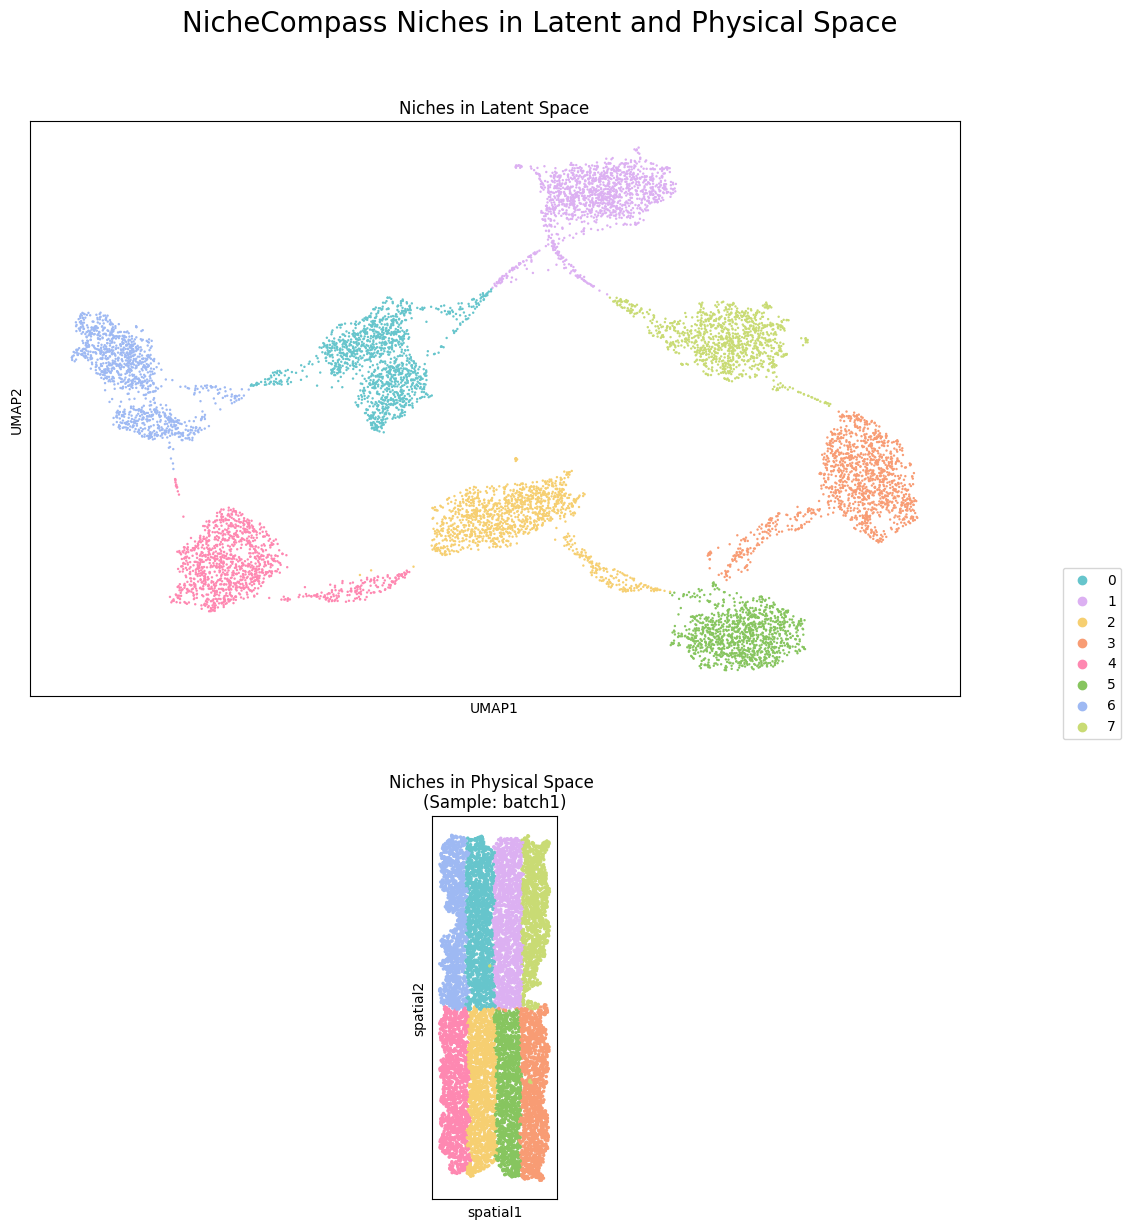

Prepare enriched and incremented GPs for GP recovery evaluation...
Compute GP recovery metrics for enriched GPs...
Compute GP recovery metrics for random GPs...
Compute niche identification metrics...
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1105, n_cat_covariates_embed_input: 0, n_hidden: 440, n_latent: 297, n_addon_latent: 143, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_output: 1105
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_out

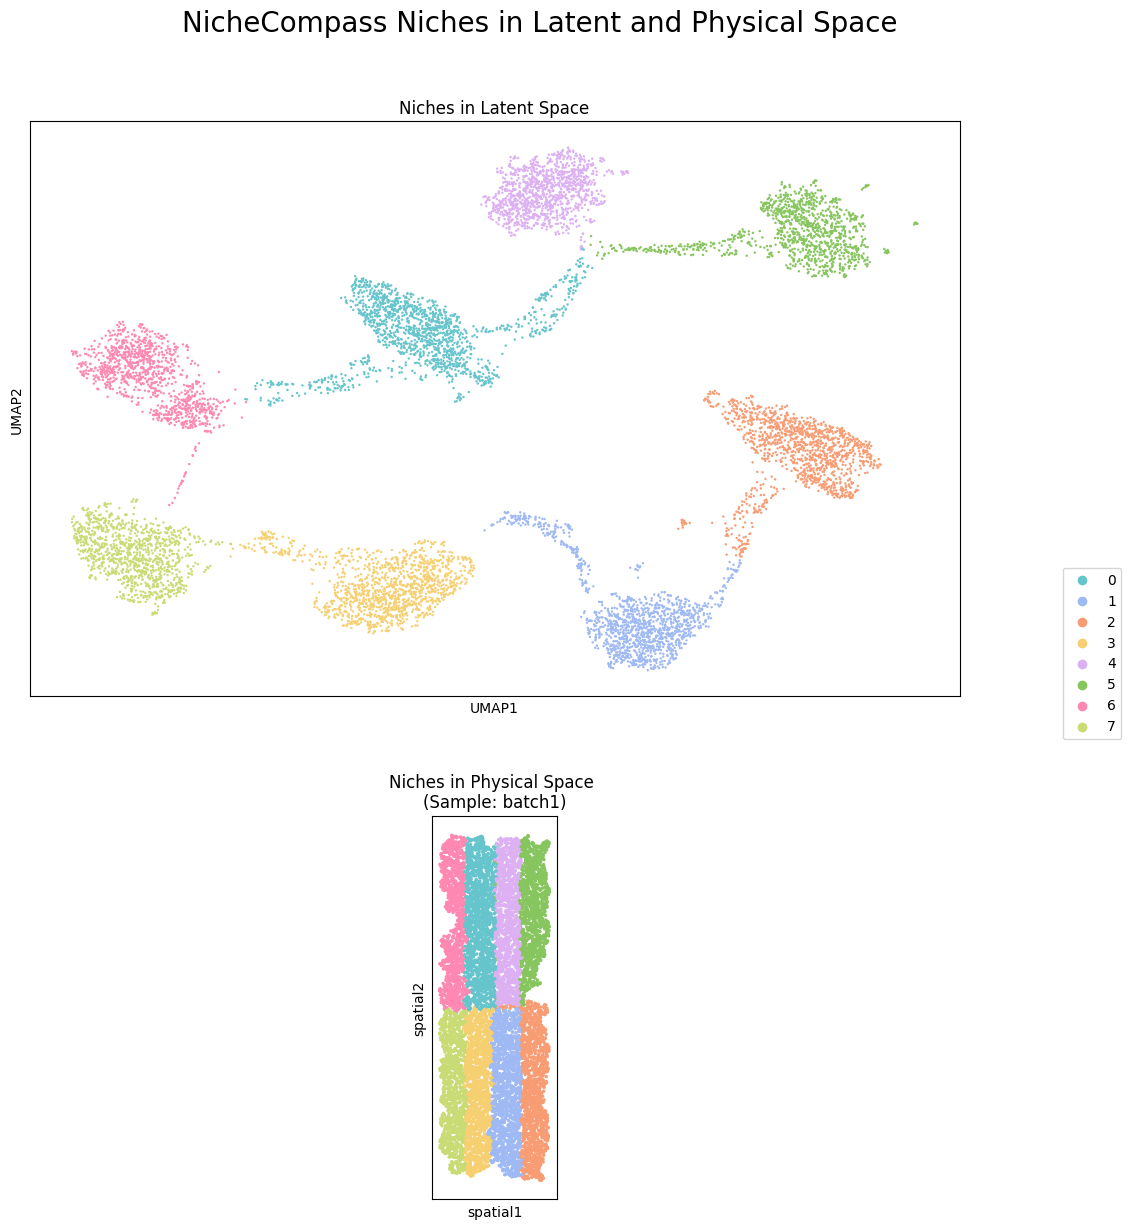

Prepare enriched and incremented GPs for GP recovery evaluation...
Compute GP recovery metrics for enriched GPs...
Compute GP recovery metrics for random GPs...
Compute niche identification metrics...
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1105, n_cat_covariates_embed_input: 0, n_hidden: 440, n_latent: 297, n_addon_latent: 143, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_output: 1105
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_out

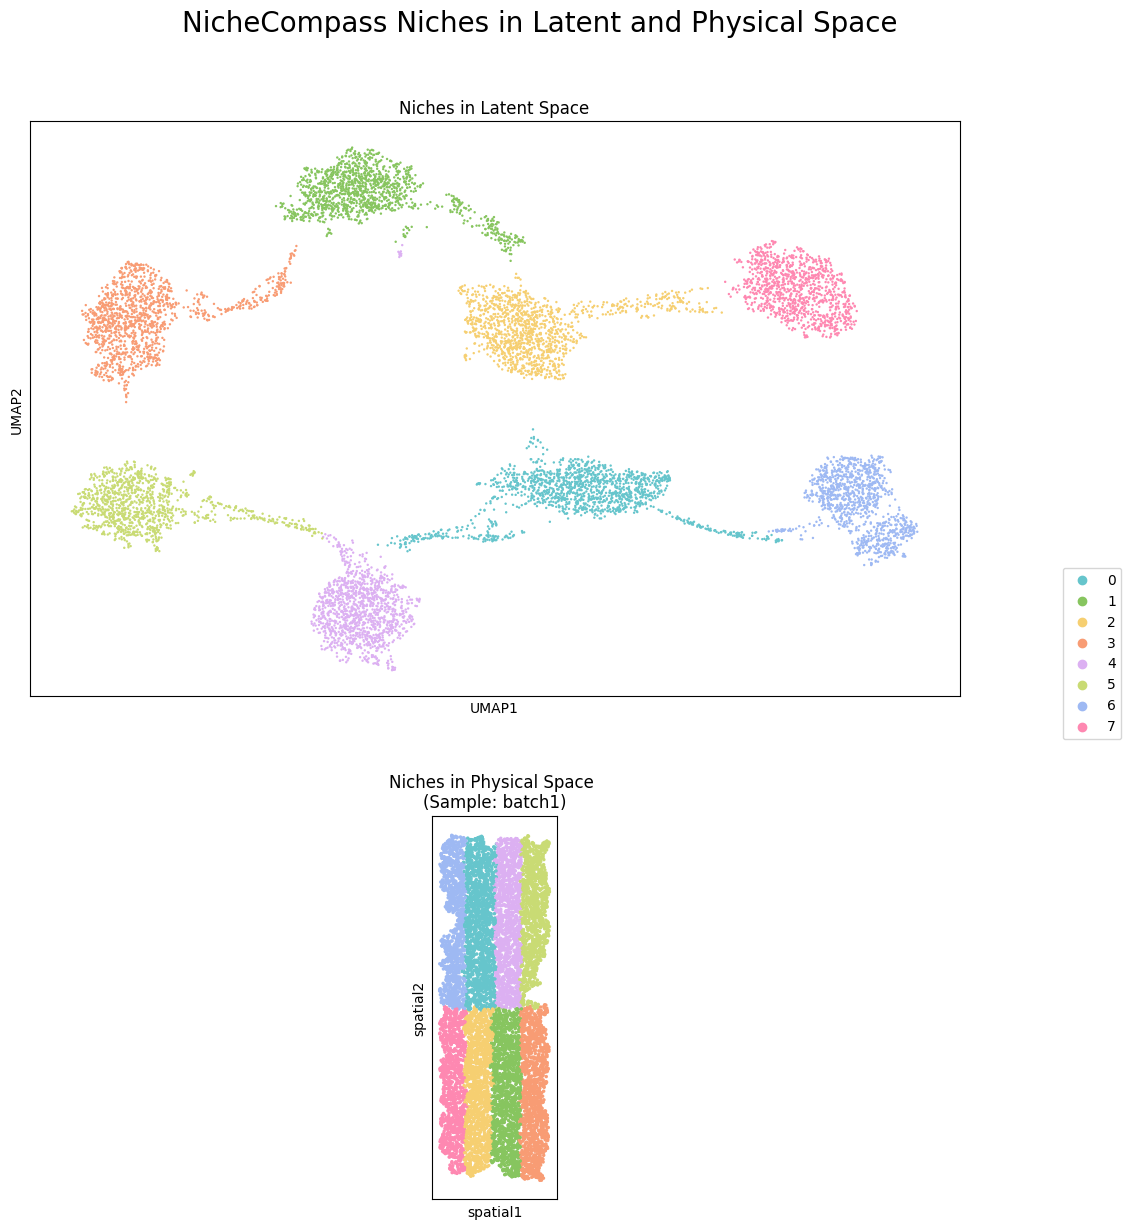

Prepare enriched and incremented GPs for GP recovery evaluation...
Compute GP recovery metrics for enriched GPs...
Compute GP recovery metrics for random GPs...
Compute niche identification metrics...
--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, rna_recon_loss: nb
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.01
LOG VARIATIONAL -> True
ONE HOP GCN NORM RNA NODE LABEL AGGREGATOR
ENCODER -> n_input: 1105, n_cat_covariates_embed_input: 0, n_hidden: 440, n_latent: 297, n_addon_latent: 143, n_fc_layers: 1, n_layers: 1, conv_layer: gatv2conv, n_attention_heads: 4, dropout_rate: 0.0, 
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED TARGET RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_output: 1105
MASKED SOURCE RNA DECODER -> n_prior_gp_input: 297, n_addon_gp_input: 143, n_cat_covariates_embed_input: 0, n_out

In [ ]:
### ### Define model configuration ###
#################################
ablation = "loss_ablation"
mlflow.set_experiment(ablation)

config = {}
config["n_neighbors"] = [6] * 5
config["conv_layer_encoder"] = ["gatv2conv"] * 5
config["active_gp_thresh_ratio"] = [0.01] * 5
config["n_addon_gp"] = [len([gp for gp in simulation_gps if "Add-On" in gp])] * 5
config["lambda_edge_recon"] = [500000.] * 5
config["lambda_gene_expr_recon"] = [300.] * 5
config["lambda_l1_masked"] = [50., 30., 50., 0., 0.]
config["lamba_l1_addon"] = [50., 30., 300., 50., 300.]
n_runs = max((len(lst) for lst in config.values() if isinstance(lst, list)), default=0)


#################################
### Define eval configuration ###
#################################
log_bayes_factor_thresh = 2.3 # (see https://en.wikipedia.org/wiki/Bayes_factor)
increment_params = [1, 3, 5, 8]
n_seeds = 1000
n_model_seeds = 8


#################################
### Run simulation ###
#################################
# Initialize run dict
run_dict = {}
run_dict["run_number"] = []
run_dict["model_seed"] = []
for k in config.keys():
    run_dict[k] = []
for element_type in [
    "prior_gps"
]:
    run_dict[f"f1_enriched_{element_type}"] = []
    run_dict[f"precision_enriched_{element_type}"] = []
    run_dict[f"recall_enriched_{element_type}"] = []
    run_dict[f"jaccard_index_enriched_{element_type}"] = []
    run_dict[f"f1_random_{element_type}"] = []
    run_dict[f"precision_random_{element_type}"] = []
    run_dict[f"recall_random_{element_type}"] = []
    run_dict[f"jaccard_index_random_{element_type}"] = []
    for increment_param in increment_params:
        run_dict[f"zscore_{element_type}_increment_param_{increment_param}"] = []
for element_type in [
    "prior_gp_source_genes",
    "prior_gp_target_genes",
    "denovo_gp_source_genes",
    "denovo_gp_target_genes"
]:
    for n in [3, 5, 10]:
        top_n_element_type = element_type + f"_top{n}"
        run_dict[f"f1_enriched_{top_n_element_type}"] = []
        run_dict[f"precision_enriched_{top_n_element_type}"] = []
        run_dict[f"recall_enriched_{top_n_element_type}"] = []
        run_dict[f"jaccard_index_enriched_{top_n_element_type}"] = []
        run_dict[f"f1_random_{top_n_element_type}"] = []
        run_dict[f"precision_random_{top_n_element_type}"] = []
        run_dict[f"recall_random_{top_n_element_type}"] = []
        run_dict[f"jaccard_index_random_{top_n_element_type}"] = []
        for increment_param in increment_params:
            run_dict[f"zscore_{top_n_element_type}_increment_param_{increment_param}"] = []
run_dict["ari"] = []
run_dict["nmi"] = []
run_dict["chaos"] = []
run_dict["pas"] = []
run_dict["asw"] = []
run_dict["hom"] = []
run_dict["com"] = []
run_dict["moranI"] = []
run_dict["gearyC"] = []


# Loop through hyperparams (different model runs)
for run_number in range(1, n_runs+1):

    # Loop through random seeds
    for model_seed in range(n_model_seeds):
        with mlflow.start_run() as run:

            run_dict["run_number"].append(int(run_number))
            run_dict["model_seed"].append(int(model_seed))
            mlflow_experiment_id = f"{ablation}_{dataset_name}_{run_number}_{model_seed}"
            
            # Add hyperparams from config
            for k, v in config.items():
                if isinstance(config[k], list):
                    run_dict[k].append(config[k][run_number-1])
                else:
                    run_dict[k].append(v)
                
            run_dict = run_simulation(combined_gp_dict,
                                      run_dict,
                                      mlflow_experiment_id)

            # Store current results
            run_df = pd.DataFrame(run_dict.values(), index=run_dict.keys()).T
            run_df.to_csv(f"{artifacts_folder_path}/ablation/{ablation}_results_11.csv", index=False)

In [ ]:
#################################
### Define model configuration ###
#################################
ablation = "loss_ablation"
mlflow.set_experiment(ablation)

config = {}
config["n_neighbors"] = [6] * 5
config["conv_layer_encoder"] = ["gatv2conv"] * 5
config["active_gp_thresh_ratio"] = [0, 0.01, 0.03, 0.1, 0.3]
config["n_addon_gp"] = [len([gp for gp in simulation_gps if "Add-On" in gp])] * 5
config["lambda_edge_recon"] = [500000.] * 5
config["lambda_gene_expr_recon"] = [300.] * 5
config["lambda_l1_masked"] = [0., 0., 0., 0., 0.]
config["lamba_l1_addon"] = [0., 0., 0., 0., 0.]
n_runs = max((len(lst) for lst in config.values() if isinstance(lst, list)), default=0)


#################################
### Define eval configuration ###
#################################
log_bayes_factor_thresh = 2.3 # (see https://en.wikipedia.org/wiki/Bayes_factor)
increment_params = [1, 3, 5, 8]
n_seeds = 1000
n_model_seeds = 8


#################################
### Run simulation ###
#################################
# Initialize run dict
run_dict = {}
run_dict["run_number"] = []
run_dict["model_seed"] = []
for k in config.keys():
    run_dict[k] = []
for element_type in [
    "prior_gps"
]:
    run_dict[f"f1_enriched_{element_type}"] = []
    run_dict[f"precision_enriched_{element_type}"] = []
    run_dict[f"recall_enriched_{element_type}"] = []
    run_dict[f"jaccard_index_enriched_{element_type}"] = []
    run_dict[f"f1_random_{element_type}"] = []
    run_dict[f"precision_random_{element_type}"] = []
    run_dict[f"recall_random_{element_type}"] = []
    run_dict[f"jaccard_index_random_{element_type}"] = []
    for increment_param in increment_params:
        run_dict[f"zscore_{element_type}_increment_param_{increment_param}"] = []
for element_type in [
    "prior_gp_source_genes",
    "prior_gp_target_genes",
    "denovo_gp_source_genes",
    "denovo_gp_target_genes"
]:
    for n in [3, 5, 10]:
        top_n_element_type = element_type + f"_top{n}"
        run_dict[f"f1_enriched_{top_n_element_type}"] = []
        run_dict[f"precision_enriched_{top_n_element_type}"] = []
        run_dict[f"recall_enriched_{top_n_element_type}"] = []
        run_dict[f"jaccard_index_enriched_{top_n_element_type}"] = []
        run_dict[f"f1_random_{top_n_element_type}"] = []
        run_dict[f"precision_random_{top_n_element_type}"] = []
        run_dict[f"recall_random_{top_n_element_type}"] = []
        run_dict[f"jaccard_index_random_{top_n_element_type}"] = []
        for increment_param in increment_params:
            run_dict[f"zscore_{top_n_element_type}_increment_param_{increment_param}"] = []
run_dict["ari"] = []
run_dict["nmi"] = []
run_dict["chaos"] = []
run_dict["pas"] = []
run_dict["asw"] = []
run_dict["hom"] = []
run_dict["com"] = []
run_dict["moranI"] = []
run_dict["gearyC"] = []


# Loop through hyperparams (different model runs)
for run_number in range(1, n_runs+1):

    # Loop through random seeds
    for model_seed in range(n_model_seeds):
        with mlflow.start_run() as run:

            run_dict["run_number"].append(int(run_number))
            run_dict["model_seed"].append(int(model_seed))
            mlflow_experiment_id = f"{ablation}_{dataset_name}_{run_number}_{model_seed}"
            
            # Add hyperparams from config
            for k, v in config.items():
                if isinstance(config[k], list):
                    run_dict[k].append(config[k][run_number-1])
                else:
                    run_dict[k].append(v)
                
            run_dict = run_simulation(combined_gp_dict,
                                      run_dict,
                                      mlflow_experiment_id)

            # Store current results
            run_df = pd.DataFrame(run_dict.values(), index=run_dict.keys()).T
            run_df.to_csv(f"{artifacts_folder_path}/ablation/{ablation}_results_6.csv", index=False)

## 3. Miscellaneous

In [ ]:
ablation = "loss_ablation"

df_list = []
for file_path in [
    "./loss_ablation_results_save.csv",
    "./loss_ablation_results_save2.csv",
    "./loss_ablation_results_save3.csv", 
    "./loss_ablation_results_save4.csv",
]:
    df_list.append(pd.read_csv(file_path))

df = pd.concat(df_list, ignore_index=True)
df.to_csv(f"{artifacts_folder_path}/data_simulation/{ablation}_results.csv", index=False)

In [ ]:
model.add_active_gp_scores_to_obs()

gp = "Spag11b_ligand_receptor_target_gene_GP"
gp_summary_df[gp_summary_df["gp_name"] == gp]
# Visualize niche types in tissue
sq.pl.spatial_scatter(model.adata, color=gp, shape=None) 
# Visualize niche types in tissue
sq.pl.spatial_scatter(model.adata, color="Spag11b", shape=None) 

In [ ]:
output_df = pd.DataFrame([[nmi,hom,com,chaos,pas,asw,moranI,gearyC]],
               index = ["NicheCompass"],#your method name
               columns=[['Accuracy','Accuracy','Accuracy','Continuity','Continuity','Continuity','Marker score','Marker score'],
                        ['NMI','HOM','COM','CHAOS','PAS','ASW','Moran\'I','Geary\'s C']])

In [ ]:
gp_eval_df["incremented_prior_gps"]["Region5"]

In [ ]:
gp_eval_df

In [ ]:
gp_eval_df["incremented_denovo_gps"]["Region5"]

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_all_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gp_start_idx=0,
    n_top_enriched_gp_end_idx=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)

In [ ]:
network_df = compute_communication_gp_network(
    gp_list=[gp],
    model=model,
    group_key=latent_cluster_key,
    n_neighbors=n_neighbors)

visualize_communication_gp_network(
    adata=model.adata,
    network_df=network_df,
    figsize=(3, 7),
    cat_colors=latent_cluster_colors,
    edge_type_colors=["#1f77b4"], 
    cat_key=latent_cluster_key,
    save=True,
    save_path=f"{figure_folder_path}/gp_network_{gp_name}.svg",
    )